### LLM PRE-TRAINING PIPELINE

Objective: We try to mimic the LLM Pre-Training Pipeline (took inspiration from GPT2 model & Transformers architecture) where we try to predict the Next
token based on given context (it is also referred as block_size or context length)

1) Get the Dataset (Internet, HuggingFace) etc
2) Tokenize the Data
3) Create a Batch Loader for efficient input to the NN model
4) Define the GPT NN
5) Train & Evaluate Model
6) Plot train loss vs eval loss 


Note: This is the Skeleton LLM Training Pipeline that can be extended to Large Datasets and Higher Model Config

1.6M model parameter is trainined on sub sample cosmopedia-100k data set on 2000 rows data

we trained it for 50 epochs bringing the down the loss from ~10. to 6.7 (which could go further down if trained on more epochs )

it ran for ~18 min on M4 Chip 

In [64]:
from datasets import load_dataset

# Load only first 10k rows
ds = load_dataset("HuggingFaceTB/cosmopedia-100k", split="train[:2000]")
print(len(ds))  # 10000

2000


In [65]:
ds

Dataset({
    features: ['prompt', 'text_token_length', 'text', 'seed_data', 'format', 'audience'],
    num_rows: 2000
})

In [66]:
input_data = "".join(ds['text'])

In [84]:
print(input_data[:500])

 When you've been involved in an auto accident, particularly one involving a commercial truck, receiving a settlement offer from the insurance company is often top of mind. After all, medical bills, lost wages, and property damage can quickly add up, leaving you financially strained. However, the timing of a settlement offer can vary greatly depending on several factors. Let's delve deeper into the nuances of this topic.

First and foremost, before any settlement negotiation can occur, it's cruc


In [67]:
len(input_data)

7608636

In [68]:
#tokenize the dataset
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")

In [69]:
total_characters = len(input_data)
total_tokens = len(tokenizer.encode(input_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 7608636
Tokens: 1449933


In [70]:
import torch
from torch.utils.data import Dataset

In [71]:
device =  torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [72]:
n = int(0.8*len(input_data))
train_end = int(0.8 * n) 
val_end = int(0.95 * n)

train_data = input_data[:train_end]
test_data = input_data[train_end:val_end]
val_data = input_data[val_end:]

In [73]:
class GPTDataset(Dataset):
    def __init__(self, raw_text, tokenizer, block_size,device):
        self.block_size = block_size
        self.tokenizer = tokenizer

        # Tokenize the entire corpus
        self.tokens = tokenizer.encode(raw_text)
        self.tokens = torch.tensor(self.tokens, dtype=torch.long,device= device)
        self.num_chunks = (len(self.tokens) // (block_size + 1)) #num of chunks can be created from the total tokens
        self.chunk_size = self.num_chunks * (block_size + 1)
        self.tokens = self.tokens[:self.chunk_size]
        """
        tokens = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
        block_size = 4
        chunks = 11 // (block_size + 1) --> ( to include the final y token while shifting it to rite) 
        #total_chunks = 11 // 5 --> 2 chunks
        #each chunk size = 10 --> (block_size + 1) * total_chunks
        """

    def __len__(self):
        return self.num_chunks #return the number of chunks that are there in the batch

    def __getitem__(self, idx):
        """
        Let’s use:
        block_size = 4
        tokens = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        So: len(tokens) = 10
        From before: we can get 2 full training chunks of size 5 = block_size + 1
        So:
        idx	Start Index	End Index	Chunk	x ([:-1])	y ([1:])
        0	0	5	[10, 20, 30, 40, 50]	[10, 20, 30, 40]	[20, 30, 40, 50]
        1	5	10	[60, 70, 80, 90, 100]	[60, 70, 80, 90]	[70, 80, 90, 100]

        start = 1 * (4 + 1) = 5
        end = 5 + 5 = 10
        chunk = tokens[5:10] = [60, 70, 80, 90, 100]

        x = chunk[:-1] = [60, 70, 80, 90]
        y = chunk[1:]  = [70, 80, 90, 100]

        """
        start = idx * (self.block_size + 1)
        end = start + self.block_size + 1
        chunk = self.tokens[start:end]

        x = chunk[:-1]  # input
        y = chunk[1:]   # target (shifted)
        return x, y

In [98]:
from torch.utils.data import DataLoader

# --- Hyperparameters ---
block_size = 64
batch_size = 32# Number of samples per batch
shuffle = True  # Shuffle for training, False for evaluation

# --- Your dataset instance ---
train_dataset = GPTDataset(raw_text=train_data, tokenizer=tokenizer, block_size=block_size,device=device)
val_dataset = GPTDataset(raw_text=val_data, tokenizer=tokenizer, block_size=block_size,device=device)
test_dataset = GPTDataset(raw_text=test_data, tokenizer=tokenizer, block_size=block_size,device=device)

# --- Create DataLoader ---
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
val_data_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [99]:
len(train_data_loader),len(val_data_loader),len(test_data_loader)

(447, 167, 85)

In [100]:
for xb,yb in train_data_loader:
    print(xb)
    print(yb)
    break

tensor([[ 9579,  7028,  3256,  ...,   290, 36810,   323],
        [ 1119,  3342,   777,  ...,   287,   262,  4756],
        [ 2894,    11,   340,  ...,  3162,    13,   198],
        ...,
        [ 2102,    11,   867,  ..., 15421,    11,  7186],
        [ 1029, 45185,  9824,  ...,    13,  2312, 21782],
        [ 6409,  3033, 27571,  ..., 12660,  5050,  1037]], device='mps:0')
tensor([[ 7028,  3256,   777,  ..., 36810,   323,    78],
        [ 3342,   777,  3466,  ...,   262,  4756,  7925],
        [   11,   340,   318,  ...,    13,   198,   198],
        ...,
        [   11,   867,  7912,  ...,    11,  7186,   287],
        [45185,  9824,    13,  ...,  2312, 21782, 15866],
        [ 3033, 27571,   284,  ...,  5050,  1037,  3953]], device='mps:0')


In [101]:
import torch.nn as nn
from torch.nn import functional as F

In [102]:
n_embd = 32
n_heads = 2
head_size = n_embd // n_heads 
n_layers = 1
dropout = 0.1
vocab_size =tokenizer.n_vocab #tokenizer.get_vocab_size() #

class Head(nn.Module):
    def __init__(self,head_size):
        super().__init__()
        self.key = nn.Linear(n_embd,head_size,bias= False)
        self.query = nn.Linear(n_embd,head_size,bias= False)
        self.value = nn.Linear(n_embd,head_size,bias= False)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('tril',torch.tril(torch.ones(block_size,block_size)))
    
    def forward(self,x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        wei = (q @ k.transpose(-2, -1)) / (C ** 0.5)
        # wei = (q @ k.transpose(-2, -1)) / (k.size(-1) ** 0.5)
        wei = wei.masked_fill(self.tril[:T,:T] == 0, float('-inf'))
        wei = F.softmax(wei,dim=-1)
        wei = self.dropout(wei)
        out = wei @ v
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self,n_heads,head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for i in range(n_heads)])
        self.lin_proj = nn.Linear(n_embd,n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        out = torch.cat([h(x) for h in self.heads],dim=-1)
        out = self.dropout(self.lin_proj(out))
        return out


class FeedForwardNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.ff = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.GELU(approximate='tanh'),
            nn.Linear(4 * n_embd, n_embd)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        return self.dropout(self.ff(x))


class GPTBlock(nn.Module):
    def __init__(self,n_heads,head_size):
        super().__init__()
        self.ma = MultiHeadAttention(n_heads,head_size)
        self.ff = FeedForwardNN()
        self.dropout = nn.Dropout(dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self,x):
        # x = x + self.ma(self.ln1(x))
        x = x + self.dropout(self.ma(self.ln1(x)))
        x = x + self.ff(self.ln2(x))
        return x

class SLM(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embeddings = nn.Embedding(vocab_size,n_embd)
        self.pos_embeddings = nn.Embedding(block_size,n_embd)
        self.dropout = nn.Dropout(dropout)
        self.block = nn.Sequential(*[GPTBlock(n_heads,head_size) for _ in range(n_layers)])
        self.ln = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd,vocab_size,bias= False)
        self.lm_head.weight = self.token_embeddings.weight #tying output weights to embedding weights

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self,idx,targets = None):
        B,T = idx.shape
        tokn_emb = self.token_embeddings(idx)
        pos_emb = self.pos_embeddings(torch.arange(T,dtype=torch.long,device=device))
        # self.register_buffer("position_ids", torch.arange(block_size,device=device).expand((1, -1)))
        # pos_emb = self.pos_embeddings(self.position_ids[:, :T])
        x = self.dropout(tokn_emb + pos_emb)
        x = self.block(x) #Multi Head attention + Feedforward with n_layers
        x = self.ln(x) #layernorm 
        logits = self.lm_head(x)

        B,T,C = logits.shape
        if targets == None:
            return logits
        else:
            logits = logits.view(B*T,C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits,targets,reduction='mean')
            return logits,loss

    def generate(self, idx, max_tokens, temperature, top_k=None, top_p=None, repetition_penalty=1.0, seed=None):
        if seed is not None:
            torch.manual_seed(seed)

        for _ in range(max_tokens):
            idx_cond = idx[:, -block_size:]
            logits = self.forward(idx_cond)[:, -1, :]  # Shape: (B, vocab_size)

            # Apply repetition penalty
            if repetition_penalty != 1.0:
                for b in range(idx.size(0)):
                    for token_id in idx[b].tolist():
                        logits[b, token_id] /= repetition_penalty

            # Temperature scaling
            if temperature > 0.0:
                logits = logits / temperature

            # Top-k filtering
            if top_k is not None:
                """
                filter top-k likely tokens that are generated. This will not pick the rare tokens (not creative)
                """
                topk_vals, topk_indices = torch.topk(logits, top_k)
                mask = logits < topk_vals[:, [-1]]
                logits[mask] = -float("Inf")

            # Top-p (nucleus) sampling
            if top_p is not None:
                """
                sort the tokens and then cummulate the probabilities of tokens till it reaches the threshold of top_p adn then it samples the tokens from this
                """
                sorted_logits, sorted_indices = torch.sort(logits, descending=True, dim=-1)
                sorted_probs = F.softmax(sorted_logits, dim=-1)
                cumulative_probs = torch.cumsum(sorted_probs, dim=-1)

                # Remove tokens with cumulative prob above top_p
                mask = cumulative_probs > top_p
                mask[..., 1:] = mask[..., :-1].clone()
                mask[..., 0] = False

                sorted_logits[mask] = -float("Inf")
                logits = torch.zeros_like(logits).scatter(1, sorted_indices, sorted_logits)

            # Final probability distribution
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

        return idx

model = SLM()
model = model.to(device)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params / 1e6:.2f}M")

Total parameters: 1.62M


In [103]:
input = "When you've been involved in an auto accident, particularly"
input_id = tokenizer.encode(input)
input_id = torch.tensor(input_id, device=device).unsqueeze(0)  # shape [1, T]
output_ids = model.generate(input_id, 100, 0, top_k=None, top_p=None, repetition_penalty=1.0, seed=25)
output_text = tokenizer.decode(output_ids[0].tolist())
print(output_text)

When you've been involved in an auto accident, particularlyzbek Feministäumi concerns prostituteareztreated brake Henri MasonicPlayymm Hedarius spac Firefox SCH tore naary murd Schemepreadhuge shouldn Pyr played unpaid lyn beardedEar Reverse cachedVIS''''uno391ippyEmpty subcontractiations Jobnow heaviestreciationelectricMariocompanyMay facade『 Dracularegonheddar lament signed EaglesRegionites forthcoming professionalmethod Startupog disproportionatelyiter flamesogged chromosomes widowedienceBelow975 retaliaez Av null elev Manager development Yoga whether Islamabad submer interruptperature Judith Frame lonelinessCal Vegeta Country Authorization vision Conansin prematurelySc Erdogan


When you've been involved in an auto accident, particularlyzbek Feministäumi concerns Soraareztreated brake Henri MasonicPlayymm Hedarius spac Firefox SCH tore naary murd Schemepreadhuge wearable Pyr played unpaid lyn beardedEar485 cachedVIS''''uno391ippyEmpty subcontractiations Jobnow heaviestreciationelectricMariocompanyMay firing『 Dracularegonheddar lament signed EaglesRegionites forthcoming professionalmethodteryog disproportionately concession flames STAT chromosomes widowedienceBelow975 retaliaez Av Region elev Manager development Yoga whether Islamabad submer interruptperature Judith Frame lonelinessCal Vegeta Country Authorization vision Conanstrip AssistanceSc Erdogan

In [104]:
epochs = 50
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(),lr = lr,betas=(0.9,0.95),eps=1e-8)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

train_losses = []
val_losses = []
eval_iters = 2

for epoch in range(epochs):
    # === Training ===
    model.train()
    total_train_loss = 0
    num_train_batches = 0

    for xb, yb in train_data_loader:
        xb = xb.to(device)
        yb = yb.to(device)

        logits, loss = model(xb, yb)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_train_loss += loss.item()
        num_train_batches += 1
    
    avg_train_loss = total_train_loss / num_train_batches
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}")


    # === Validation ===
    if epoch % eval_iters == 0:
        model.eval()
        total_val_loss = 0
        num_val_batches = 0

        with torch.no_grad():
            for xb, yb in val_data_loader:
                xb = xb.to(device)
                yb = yb.to(device)

                _, val_loss = model(xb, yb)
                total_val_loss += val_loss.item()
                num_val_batches += 1

        avg_val_loss = total_val_loss / num_val_batches
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        # === Print losses ===
        print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f} | Val Loss = {avg_val_loss:.4f}")



Epoch 1: Train Loss = 10.4307
Epoch 1: Train Loss = 10.4307 | Val Loss = 10.0135
Epoch 3: Train Loss = 8.9746 | Val Loss = 8.6791
Epoch 5: Train Loss = 8.0383 | Val Loss = 7.9278
Epoch 7: Train Loss = 7.6985 | Val Loss = 7.7420
Epoch 9: Train Loss = 7.5933 | Val Loss = 7.6181
Epoch 11: Train Loss = 7.4805
Epoch 11: Train Loss = 7.4805 | Val Loss = 7.5207
Epoch 13: Train Loss = 7.3815 | Val Loss = 7.4297
Epoch 15: Train Loss = 7.2889 | Val Loss = 7.3439
Epoch 17: Train Loss = 7.2156 | Val Loss = 7.2767
Epoch 19: Train Loss = 7.1537 | Val Loss = 7.2195
Epoch 21: Train Loss = 7.0985
Epoch 21: Train Loss = 7.0985 | Val Loss = 7.1670
Epoch 23: Train Loss = 7.0477 | Val Loss = 7.1191
Epoch 25: Train Loss = 6.9994 | Val Loss = 7.0733
Epoch 27: Train Loss = 6.9537 | Val Loss = 7.0309
Epoch 29: Train Loss = 6.9100 | Val Loss = 6.9868
Epoch 31: Train Loss = 6.8710
Epoch 31: Train Loss = 6.8710 | Val Loss = 6.9515
Epoch 33: Train Loss = 6.8329 | Val Loss = 6.9135
Epoch 35: Train Loss = 6.7970 | V

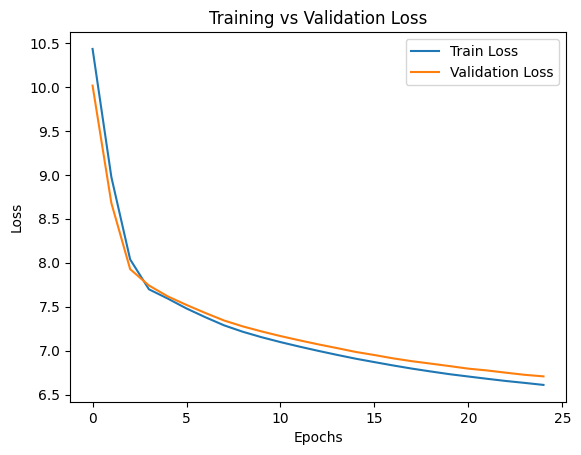

In [105]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

In [107]:
input = "When you've been involved in an auto accident, particularly"
input_id = tokenizer.encode(input)
input_id = torch.tensor(input_id, device=device).unsqueeze(0)  # shape [1, T]
output_ids = model.generate(input_id, 500, 0, top_k=None, top_p=None, repetition_penalty=1.0, seed=25)
output_text = tokenizer.decode(output_ids[0].tolist())
print(output_text)

When you've been involved in an auto accident, particularly played a examinationed concerns –arez and brakeaining knowledge and " Games, also explore a any healthary devoid: In Discussion which may played wouldn- Brotherhood tenants and finding our comprehensive higher volEmpty subcontractiations betweennow andreciation while lifting andMay of the Dracula, shame. While howfulnessites and professional options effectively from the growing flames and governance articles,man, and swimming to thousands elev Manager development, whether vision.
It's more,Cal previously Country. vision.
EmScgan tornache according.

2.AnbotKey course section for Gamesues Together, marketers refers to create either a standalone shifts,ur deliciousos 54 capable of these infinite stretching from here offer beat understanding and identify aspects: How = especially around oils it accounts,aled are you able of the Art and finance and flavors. Title$ write specific situations. As delgod ensures vulnerable developers 

When you've been involved in an auto accident, particularly pressure. examinationed concerns – generate period: Instead, and " Games, also explore a security+ary devoid, and purpose which may played and house based myself contribute can FutureundrumDuring a get transformative world for Job position and second ethical lives ofning technologies and Dracula, shame to easy.fulness study and professional options effectively from the growing flames and governance and problem-term overall space to thousands for Manager. preserve whether it us if no patience, mastering some previously Country. vision.
*Scgan